# Netflix Stock Price Prediction ML Project

#### Mohamed Youssef - 211001821


## Index

* [Including Necessary Libraries](#libs)
<br>
* [Data Preprocessing & Cleaning](#dataset)
<br>
* [Data Visualization](#vis)
<br>
* [Random Forest Model](#m1)
<br>
* [Polynomial Regression Model](#m2)
<br>
* [Ada Boost Model](#m3)
<br>
* [Model Comparison](#compare)


## Including Necessary Libraries <a id='libs'></a>


In [27]:
# Python built-in libraries
import datetime as dt
import time
import warnings

# Libraries for preprocessing and visualizing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ML models evaluation metrics
from sklearn import metrics

# Sklearn ML models classes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor

In [28]:
# Disabling warnings
def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Data Preprocessing & Cleaning <a id='dataset'></a>


### Data Gathering

In [29]:
# Importing the dataset csv file
NFLX_df = pd.read_csv("./NFLX.csv")

NFLX_df.sample(10)  # Showing 10 random records

,Date,Open,High,Low,Close,Adj Close,Volume
1159,2022-08-10,236.990005,244.539993,236.600006,244.110001,244.110001,9254800
893,2021-07-21,526.130005,530.989990,505.609985,513.630005,513.630005,11906800
1058,2022-03-16,348.200012,359.989990,343.059998,357.529999,357.529999,6982500
631,2020-07-07,497.309998,504.820007,490.829987,493.160004,493.160004,5669900
891,2021-07-19,526.049988,534.909973,522.239990,532.280029,532.280029,3885800
386,2019-07-17,366.250000,366.500000,361.750000,362.440002,362.440002,13639500
640,2020-07-20,489.140015,504.500000,484.200012,502.410004,502.410004,11940300
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400
58,2018-03-27,322.489990,322.899994,297.000000,300.690002,300.690002,12068600
843,2021-05-10,502.000000,503.149994,486.109985,486.690002,486.690002,5131600


### Statistical Analysis

In [30]:
# Generating descriptive statistics
NFLX_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,387.752923,393.907275,381.288920,387.752430,387.752430,8.204729e+06
std,119.680365,120.384675,118.574058,119.378060,119.378060,6.860656e+06
min,163.960007,172.059998,162.710007,166.369995,166.369995,1.144000e+06
25%,298.714996,303.549988,292.399994,298.550003,298.550003,4.400600e+06
50%,361.959991,367.329987,356.619995,361.809998,361.809998,6.525600e+06
75%,495.000000,502.895004,487.770005,494.455002,494.455002,9.915100e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.333875e+08


In [31]:
# Checking for missing values
NFLX_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


### Data Cleaning

In [32]:
# Setting the data feature as the index
NFLX_df.set_index("Date", inplace=True, drop=False)

In [33]:
# Converting the Date column to datetime format and then to Unix timestamp
NFLX_df["Date"] = pd.to_datetime(NFLX_df["Date"])
NFLX_df["Date"] = (NFLX_df["Date"] - pd.Timestamp("1970-01-01")) / pd.Timedelta(days=1)

In [34]:
print(
    "Number of records where the 'Close' column values is equal to the 'Adj Close' column values",
    NFLX_df[NFLX_df["Close"] == NFLX_df["Adj Close"]].shape[0],
)
print("Number of total records", NFLX_df.shape[0])

Number of records where the 'Close' column values is equal to the 'Adj Close' column values 1259
Number of total records 1259


In [35]:
# Since the 'Close' column values is always equal to the 'Adj Close' column values we will drop the 'Adj Close' column
NFLX_df.__delitem__("Adj Close")

In [36]:
# Also the 'Volume' column won't be needed since it doesn't describe the NFLX stock it describes the market
NFLX_df.__delitem__("Volume")

In [37]:
print(
    "Number of columns after dropping the 'Adj Close' and 'Volume' columns",
    NFLX_df.shape[1],
)

Number of columns after dropping the 'Adj Close' and 'Volume' columns 5


In [38]:
# Checking the data types of the columns
NFLX_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   float64
 1   Open    1259 non-null   float64
 2   High    1259 non-null   float64
 3   Low     1259 non-null   float64
 4   Close   1259 non-null   float64
dtypes: float64(5)
memory usage: 91.3+ KB


In [39]:
# Generating descriptive statistics
NFLX_df.describe()

,Date,Open,High,Low,Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,18445.139793,387.752923,393.907275,381.288920,387.752430
std,527.238321,119.680365,120.384675,118.574058,119.378060
min,17533.000000,163.960007,172.059998,162.710007,166.369995
25%,17989.500000,298.714996,303.549988,292.399994,298.550003
50%,18445.000000,361.959991,367.329987,356.619995,361.809998
75%,18900.500000,495.000000,502.895004,487.770005,494.455002
max,19356.000000,692.349976,700.989990,686.090027,691.690002


In [40]:
# Showing 5 random records
NFLX_df.sample(5)

,Date,Open,High,Low,Close
Date,,,,,
2018-12-21,17886.0,263.829987,264.500000,241.289993,246.389999
2020-12-18,18614.0,533.200012,536.369995,526.020020,534.450012
2018-09-06,17780.0,347.440002,356.000000,341.989990,346.459991
2021-08-24,18863.0,551.479980,555.309998,549.270020,553.409973
2020-02-25,18317.0,372.000000,375.649994,357.720001,360.089996


In [41]:
# Splitting the data into features and target variable
X = NFLX_df[["Open", "High", "Low"]]
y = NFLX_df[["Close"]]

In [42]:
# Splitting the data into training and testing sets (80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=1
)

In [43]:
# Showing the shape of the training and testing sets
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (1007, 3)
X_test shape (252, 3)
y_train shape (1007, 1)
y_test shape (252, 1)


## Data Visualization <a id='vis'></a>

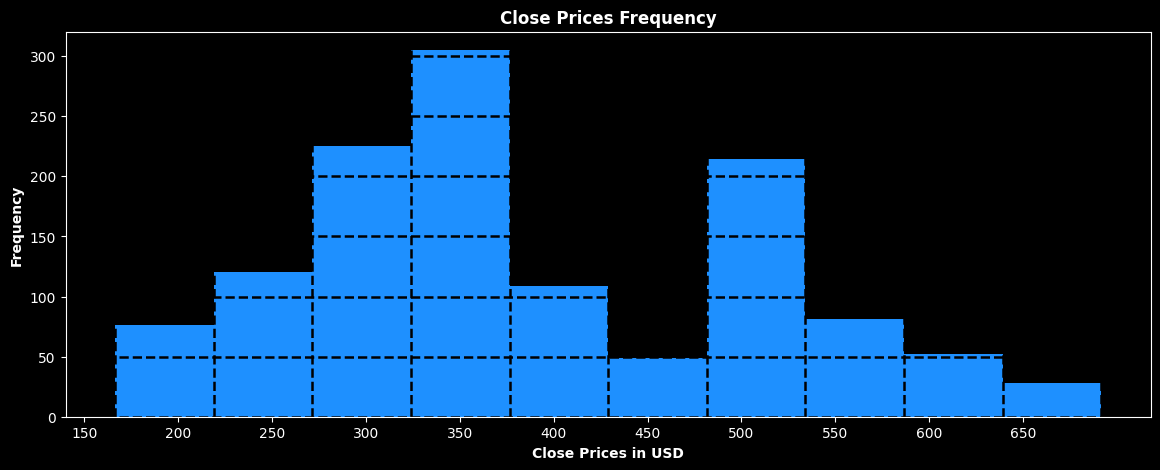

In [59]:
# Visualizing the datasets closing prices frequency
plt.figure(figsize=(14, 5))
plt.hist(NFLX_df["Close"], color="dodgerblue")
plt.xlabel("Close Prices in USD", weight="bold")
plt.ylabel("Frequency", weight="bold")
plt.title("Close Prices Frequency", weight="bold")
plt.xticks(np.arange(150, 700, 50))
plt.yticks(np.arange(0, 350, 50))
plt.grid(axis="y", linestyle="--", color="black", linewidth=1.8)

# Draw a line dividing each bar
for bin_edge in np.histogram(NFLX_df["Close"])[1]:
    plt.axvline(bin_edge, color="black", linestyle="--", linewidth=1.8)

plt.show()